# 💻 Deep Learning Training Script for Dental Caries Segmentation (Colab Notebook)

This notebook contains code for training a medical image segmentation model.
Please ensure that all custom files (utils, configs, models.py) are uploaded to the Colab environment or Google Drive.

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

# Set the working directory to your project folder in Google Drive
os.chdir('/content/drive/MyDrive/Colab_Notebook/dental-caries-segmentation')

In [ ]:
# 1. 🚀 Setup: Install dependencies
!pip install albumentations==1.3.0 tqdm==4.65.0 thop==0.1.1-2209072238 yacs==0.1.8 einops==0.6.1 timm==0.4.12 fvcore==0.1.5.post20221221 distutils

import time
import datetime
import numpy as np
import cv2
from glob import glob
import torch
from torch.utils.data import Dataset, DataLoader
from utils.data import load_DC1000_data, DC1000_DATASET
from utils.utils import seeding, create_dir, print_and_save, shuffling, epoch_time, calculate_metrics
from models import UNet
from utils.train_utils import train, evaluate
from utils.plot_utils import plot_image

In [462]:
# check GPU
if torch.cuda.is_available():
    print("GPU is available.")
else:
    print("No GPU found. Using CPU.")

GPU is available.


In [463]:
# --- 1. configurations ---
class Arguments:
  def __init__(self, model, data_path, image_size, batch_size, num_epochs, lr, seed):
      self.model = model
      self.data_path = data_path
      self.image_size = image_size
      self.batch_size = batch_size
      self.num_epochs = num_epochs
      self.lr = lr
      self.early_stopping_patience = early_stopping_patience
      self.seed = seed
    
# ** Configure your model and data paths **
opt = Arguments(model='UNet', data_path='data/DC1000', image_size=(384, 384), batch_size=4, num_epochs=3, lr=1e-4, seed=42)
file_path = f"files/{opt.model}"
checkpoint_path = f"{file_path}/checkpoint.pth"
create_dir(file_path)
seeding(opt.seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [464]:
""" Data augmentation: Transforms """
import albumentations as A
transform = A.Compose([
  A.HorizontalFlip(p=0.5),
  A.ShiftScaleRotate(
  shift_limit=0.05, scale_limit=0.05, rotate_limit=15,
  interpolation=cv2.INTER_LINEAR, border_mode=cv2.BORDER_CONSTANT, p=0.3
  ),
  A.RandomBrightnessContrast(p=0.3),
])

In [465]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_DC1000_data(opt.data_path)
train_x, train_y = shuffling(train_x, train_y)
data_str = f"Dataset Size: Train: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}"
data_str

'Dataset Size: Train: 443 - Valid: 50 - Test: 100'

In [466]:
# print the first five data
for x_item, y_item in zip(train_x[:5], train_y[:5]):
    print(x_item, y_item)

data/DC1000/train/images/579.png data/DC1000/train/masks/579.png
data/DC1000/train/images/255.png data/DC1000/train/masks/255.png
data/DC1000/train/images/185.png data/DC1000/train/masks/185.png
data/DC1000/train/images/615.png data/DC1000/train/masks/615.png
data/DC1000/train/images/187.png data/DC1000/train/masks/187.png


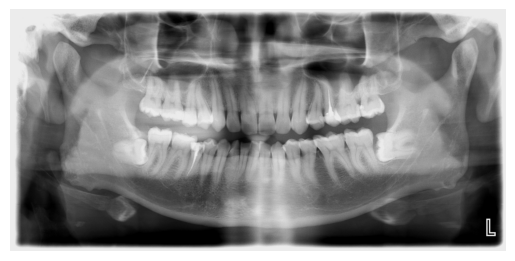

In [467]:
plot_image(train_x[1])

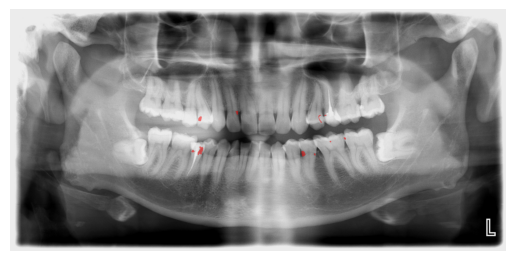

In [468]:
plot_image(train_x[1], train_y[1])

In [469]:
""" Dataset and loader """
train_dataset = DC1000_DATASET(train_x, train_y, opt.image_size, transform=transform)
valid_dataset = DC1000_DATASET(valid_x, valid_y, opt.image_size, transform=None)

train_loader = DataLoader(
  dataset=train_dataset,
  batch_size=opt.batch_size,
  shuffle=True,
  num_workers=2
)

valid_loader = DataLoader(
  dataset=valid_dataset,
  batch_size=opt.batch_size,
  shuffle=False,
  num_workers=2
)

In [470]:
""" Model, Optimizer, scheduler """
model = eval(opt.model)().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=opt.lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)


In [471]:
""" Training the model """
for epoch in range(opt.num_epochs):
  train_loss, train_metrics = train(model, train_loader, optimizer, device)
  valid_loss, valid_metrics = evaluate(model, valid_loader, device)
  scheduler.step(valid_loss)
  epoch_str = f"Epoch: {epoch+1:02} | Train Loss: {train_loss:.4f} | Val. Loss: {valid_loss:.4f} | Train F1: {train_metrics[1]:.4f} | Val. F1: {valid_metrics[1]:.4f}"
  print(epoch_str)
  if epoch == opt.num_epochs - 1:
      torch.save(model.state_dict(), checkpoint_path)

Epoch: 01 | Train Loss: 0.5056 | Val. Loss: 0.5026 | Train F1: 0.0008 | Val. F1: 0.0139
Epoch: 02 | Train Loss: 0.5021 | Val. Loss: 0.5012 | Train F1: 0.0319 | Val. F1: 0.0890
Epoch: 03 | Train Loss: 0.5008 | Val. Loss: 0.5002 | Train F1: 0.0757 | Val. F1: 0.1146
